# U.S. wildfires analysis
by [Irena Fischer-Hwang](https://github.com/ihwang)

Stanford University students in COMM 277B (Autumn 2018) conducted an analysis of wildfires in the United States for the story "Wildland development escalates California fire costs."

We found that the costs of California's most expensive wildfires dwarf those of any other state, and WUI may be to blame. This notebook summarizes our analysis.

Nomenclature notes:
* Variable names of pandas dataframes start with `df_`
* Variable names of pandas series start with `series_`
* Variable names of pandas indices start with `index_`

## Import main python packages for analysis

Import packages for computational tools

In [1]:
import numpy as np
import pandas as pd
from collections import Counter

## Data collection
This analysis is based on four data sources. They are:
1. Daily situation (SIT-209) reports from [The National Fire & Aviation Management Web Applications site](https://fam.nwcg.gov/fam-web/)
2. Fire perimeter data from [The Geospatial Multi-Agency Coordination (GeoMAC) Wildland Fire database](https://www.geomac.gov/)
3. Wildland-Urban Interface (WUI) change data from the [SILVIS Lab at the University of Washington-Madison](http://silvis.forest.wisc.edu/)
4. WUI statistics over the last twenty years, as measured in the report [The 2010 wildland-urban interface of the conterminous United States](https://www.nrs.fs.fed.us/pubs/48642)

### The National Fire & Aviation Management Web Applications data
SIT-209 reports for each year are available for download as .exe files from the dropdown menu on the left of the National Fire & Aviation Management Web Applications [site](https://fam.nwcg.gov/fam-web/).

We downloaded the SIT-209 .exe archives on November 9, 2018. The .exe archives were extracted to Microsoft Access database files (.accdb) either with a double-click on Windows, or the `unzip` command in Mac OS. The database files were then loaded table-by-table using Python open source tool [panda_access](https://github.com/jbn/pandas_access), joined and reshaped. Finally, these reshaped tables containing extracted SIT-209 data were then exported as .csv files.

We now import the extracted SIT-209 wildfires data for 2014, 2015, 2016 and 2017, and concatenate them into a single dataframe, `df_all_raw`.

Note: 
* For ease of browsing, the fires are sorted first by incident identifier (`INC_IDENTIFIER`), then by report date (`REPORT_FROM_DATE`).
* When concatenating the individual dataframes, reset the index

In [2]:
years = range(2014, 2018)
dfs = []
for year in years:
    df_year = pd.read_csv(
        './data/SIT209/fire_reports_%s.csv' %year, low_memory=False,
        parse_dates=['DISCOVERY_DATE', 'REPORT_FROM_DATE', 'REPORT_TO_DATE']
    )
    dfs.append(df_year)
df_all_raw = pd.concat(dfs, sort=False, ignore_index=True)
df_all_raw.sort_values(['INC_IDENTIFIER', 'REPORT_FROM_DATE'], inplace=True)
df_all_raw.head()
# Optional: export concatenated dataframes as a csv
df_all_raw.to_csv('./data/SIT209/fire_reports_2014-2017.csv')

We now manually correct known errors in `df_all_raw`, and save the corrected version of the dataframe as `df_all`. Known errors (based on reviewing media reports about the fires):
1. The Log Fire in CA, 2014 is part of the July Complex Fire
2. The Tubbs Fire in CA, 2017 is part of the Central LNU Complex Fire
3. Multiple records are labeled with `INCIDENT_NAME==CENTRAL LNU COMPLEX`, but only the most common `INC_IDENTIFIER` contains the correct data
4. The final cost entry for the Lightner Creek Fire in CO, 2017 (`INC_IDENTIFIER==7376820`) is inaccurate (appears to be an entry error)
5. The Roaring Lion Fire in MT, 2016 is duplicated, so drop the reports under `INC_IDENTIFIER==4310663`
6. The final cost estimate for the Okanogan Complex Fire in WA, 2015 (`INC_IDENTIFIER==2931055`) is empty, so backfill it with the previous cost
7. The Lime Belt (`INC_IDENTIFIER==2876401`), Beaver Lake (`INC_IDENTIFIER==2881651`), 9 Mile (`INC_IDENTIFIER==2884366`), and Tunk Block (`INC_IDENTIFIER==2897183`) fires are all part of the Okanogan Complex Fire in WA, 2015
8. Remove records that do not have valid `DISCOVERY_DATE`, or do not have valid `POO_STATE_CODE`

In [3]:
df_all = df_all_raw.copy(deep=True)

# 1.
df_all = df_all[df_all['INC_IDENTIFIER'] != 732812]

# 2.
df_all = df_all[df_all['INC_IDENTIFIER'] != 7241051]

# 3.
central_lnu_ids = df_all_raw[df_all_raw['INCIDENT_NAME']=='CENTRAL LNU COMPLEX']['INC_IDENTIFIER']
other_ids = list(set(central_lnu_ids).difference({Counter(central_lnu_ids).most_common(1)[0][0]}))
for other_id in other_ids:
    df_all = df_all[df_all['INC_IDENTIFIER'] != other_id]

# 4.
df_all.loc[87466, 'EST_IM_COST_TO_DATE'] = 2e6

# 5.
df_all = df_all[df_all['INC_IDENTIFIER'] != 4310663]

# 6.
df_all.loc[27615, 'EST_IM_COST_TO_DATE'] = 46296090.0

# 7.
other_ids = [2884366.0, 2881651.0, 2876401.0, 2897183.0]
for other_id in other_ids:
    df_all = df_all[df_all['INC_IDENTIFIER'] != other_id]

# 8.
df_all_clean = df_all[(df_all['DISCOVERY_DATE'].notna()) & (df_all['POO_STATE_CODE'].notna())]

df_all.sort_values(['INC_IDENTIFIER', 'REPORT_FROM_DATE'], inplace=True)

We now calculate aggregate quantities for buildings destroyed, damaged and threatened for each daily record, and save the dataframe with aggregate quantitites as `df_all_agg`. The following quantities were aggregated over multiple fields recording single family residences, multifamily residences, mixed use, etc.:
* All building types destroyed
* All building types damaged
* All building types threatened

More deatils for these fields can be found in the [ICS user guide](https://www.predictiveservices.nifc.gov/intelligence/ICS-209_User_Guide_2.0.pdf). In particular, the guide describes that fields for destroyed and damaged building types are cumulative, while fields for threatened buildings are for 72 hour periods.

In [4]:
df_all_agg = df_all_clean.copy(deep=True)
destroyed_list = [i for i in df_all_agg.columns if 'DESTROYED' in i]
df_all_agg['TOTAL_BUILDINGS_DESTROYED'] = df_all_agg[destroyed_list].sum(axis=1)
damaged_list = [i for i in df_all_agg.columns if 'DAMAGED' in i]
df_all_agg['TOTAL_BUILDINGS_DAMAGED'] = df_all_agg[damaged_list].sum(axis=1)
threatened_list = [i for i in df_all_agg.columns if 'THREATENED' in i]
df_all_agg['TOTAL_BUILDINGS_THREATENED'] = df_all_agg[threatened_list].sum(axis=1)

We get final/max quantities for each fire, and save the dataframe with final/max quantities as `df_all_final`.

Final quantities are taken for:
* suppression cost (`EST_IM_COST_TO_DATE`)
* number of buildings destroyed (`TOTAL_BUILDINGS_DESTROYED`)
* number of building damaged (`TOTAL_BUILDINGS_DESTROYED`)
* incident area (`CURR_INCIDENT_AREA`)

Max quantities are taken for:
* total number of buildings threatened (`TOTAL_BUILDINGS_THREATENED)

The columns of `df_all_final` are renamed accordingly

In [5]:
final_report_inds = [i - 1 for i in df_all_agg.groupby(['INC_IDENTIFIER']).size().cumsum()]
df_cost_destroyed_damaged_area = df_all_agg.iloc[final_report_inds][
    [
        'INCIDENT_NAME', 'DISCOVERY_DATE', 'EST_IM_COST_TO_DATE', 'POO_STATE_CODE', 'TOTAL_BUILDINGS_DESTROYED', 
        'TOTAL_BUILDINGS_DAMAGED', 'CURR_INCIDENT_AREA'
    ]
].reset_index(drop=True)
df_cost_destroyed_damaged_area.index = df_all_agg.iloc[final_report_inds]['INC_IDENTIFIER']
df_area_threatened = df_all_agg.groupby(['INC_IDENTIFIER'])['TOTAL_BUILDINGS_THREATENED'].max()
df_all_final = pd.concat([df_cost_destroyed_damaged_area, df_area_threatened], axis=1)
df_all_final.columns = [
    'INCIDENT_NAME','DISCOVERY_DATE','FINAL_COST', 'POO_STATE_CODE', 'FINAL_BUILDINGS_DESTROYED', 
    'FINAL_BUILDINGS_DAMAGED', 'FINAL_AREA', 'MAX_BUILDINGS_THREATENED'
]

### The Geospatial Multi-Agency Coordination data and SILVIS Lab WUI data
Fire perimeters data is hosted at the GeoMAC [Fire Perimeters data repository](https://rmgsc.cr.usgs.gov/outgoing/GeoMAC/). We downloaded the fire perimeters data for the top 20 most expensive fires in 2014-2017 for California, Oregon and Washington (see below).

WUI data is hosted at the [WUI Change webpage](http://silvis.forest.wisc.edu/data/wui-change/), where compressed ESRI Shapefiles (.shp) can be downloaded for states of interest. We downloaded the 2010 Shapefiles for California, Oregon and Washington.

We combined GeoMAC and WUI data by finding the intersecting areas between reported fire perimeters and WUI perimeters. For more information, please see `./data/fire_wui_zones_readme.docx`.

We now import the combined GeoMAC and WUI data into the dataframe `df_wui`:

In [6]:
df_wui = pd.read_csv('./data/fire_wui_zones.csv')

### WUI housing development statistics

Statistics about housing development in the WUI from the report "The 2010 wildland-urban interface of the conterminous United States" were found at [this US Forest webpage](https://www.nrs.fs.fed.us/data/wui/state_summary/#wui-houses) and extracted using [Tabula](http://tabula.technology).

We now import the extracted data into the dataframe `df_wui_housing`

In [7]:
df_wui_housing = pd.read_csv('./data/wui_housing.csv')
df_wui_housing.columns = [' '.join(column.split('\r')) for column in df_wui_housing.columns]
for column in list(df_wui_housing.columns)[1:]:
    if 'Percent' in column:
        df_wui_housing[column] = df_wui_housing[column].str.rstrip('%').astype('float') / 100.0
    else:
        df_wui_housing[column] = df_wui_housing[column].str.replace(',','').astype(float)
df_wui_housing.index = list(df_wui_housing['State'])
df_wui_housing = df_wui_housing.drop(columns=['State'])

## Analysis
The raw data sources are now prepared for analysis. Let's begin by importing remaining Python tools necessary for the job.

Set plotting settings

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import EllipseCollection

Import miscellaneous helpful stuff

In [9]:
import datetime as dt

Define useful variables

In [10]:
units_dict = {3: 'thousand', 6: 'million', 9: 'billion'}

state_codes = {
    'WA': '53', 'DE': '10', 'DC': '11', 'WI': '55', 'WV': '54', 'HI': '15',
    'FL': '12', 'WY': '56', 'PR': '72', 'NJ': '34', 'NM': '35', 'TX': '48',
    'LA': '22', 'NC': '37', 'ND': '38', 'NE': '31', 'TN': '47', 'NY': '36',
    'PA': '42', 'AK': '02', 'NV': '32', 'NH': '33', 'VA': '51', 'CO': '08',
    'CA': '06', 'AL': '01', 'AR': '05', 'VT': '50', 'IL': '17', 'GA': '13',
    'IN': '18', 'IA': '19', 'MA': '25', 'AZ': '04', 'ID': '16', 'CT': '09',
    'ME': '23', 'MD': '24', 'OK': '40', 'OH': '39', 'UT': '49', 'MO': '29',
    'MN': '27', 'MI': '26', 'RI': '44', 'KS': '20', 'MT': '30', 'MS': '28',
    'SC': '45', 'KY': '21', 'OR': '41', 'SD': '46'
}

codes_state = {int(j):i for (i,j) in state_codes.items()}

abb_state = {
    'AK': 'Alaska','AL': 'Alabama','AR': 'Arkansas','AS': 'American Samoa','AZ': 'Arizona','CA': 'California',
    'CO': 'Colorado','CT': 'Connecticut','DC': 'District of Columbia','DE': 'Delaware','FL': 'Florida',
    'GA': 'Georgia','GU': 'Guam','HI': 'Hawaii','IA': 'Iowa','ID': 'Idaho','IL': 'Illinois','IN': 'Indiana',
    'KS': 'Kansas','KY': 'Kentucky','LA': 'Louisiana','MA': 'Massachusetts','MD': 'Maryland','ME': 'Maine',
    'MI': 'Michigan','MN': 'Minnesota','MO': 'Missouri','MP': 'Northern Mariana Islands','MS': 'Mississippi',
    'MT': 'Montana','NA': 'National','NC': 'North Carolina','ND': 'North Dakota','NE': 'Nebraska',
    'NH': 'New Hampshire','NJ': 'New Jersey','NM': 'New Mexico','NV': 'Nevada','NY': 'New York','OH': 'Ohio',
    'OK': 'Oklahoma','OR': 'Oregon','PA': 'Pennsylvania','PR': 'Puerto Rico','RI': 'Rhode Island',
    'SC': 'South Carolina','SD': 'South Dakota','TN': 'Tennessee','TX': 'Texas','UT': 'Utah','VA': 'Virginia',
    'VI': 'Virgin Islands','VT': 'Vermont','WA': 'Washington','WI': 'Wisconsin','WV': 'West Virginia','WY': 'Wyoming'
}

### Get the total cost of the 20 most expensive fires in each state
Given the inaccuracies in the data set, we focus on the top 20 most expensive fires in each state. Here, we ranked all 50 states by the total of the top 20 most expensive fires in that state.

In [11]:
series_top20_costs = df_all_final.groupby('POO_STATE_CODE')['FINAL_COST'].\
    nlargest(20).sum(level=0).sort_values(ascending=False)
index_top20_states = series_top20_costs.index
print('State name, State code, Top 20 Suppression costs total (2014-2017)')
for (state, cost) in zip(index_top20_states, series_top20_costs):
    print('%s, %s, %s' %(
        abb_state[codes_state[state]],
        int(state),
        str(cost),
    )
         )

State name, State code, Top 20 Suppression costs total (2014-2017)
California, 6, 1499703361.0
Oregon, 41, 592279881.0
Washington, 53, 422570371.0
Montana, 30, 403739061.0
Idaho, 16, 308043876.0
New Mexico, 35, 180474502.0
Arizona, 4, 148917018.0
Alaska, 2, 112554456.0
Wyoming, 56, 107847025.0
Utah, 49, 97441853.67
Florida, 12, 77848323.0
Nevada, 32, 75894319.0
Colorado, 8, 67302192.0
North Carolina, 37, 63596728.0
Tennessee, 47, 23696318.0
South Dakota, 46, 21210000.0
Georgia, 13, 15114688.0
Oklahoma, 40, 10576000.0
Virginia, 51, 8834500.0
Texas, 48, 6537768.0
Minnesota, 27, 6183046.79
South Carolina, 45, 5350475.0
Alabama, 1, 3453607.0
Pennsylvania, 42, 2106500.0
West Virginia, 54, 1857532.0
Mississippi, 28, 1743400.0
Kentucky, 21, 1715622.1099999999
North Dakota, 38, 1413000.0
Kansas, 20, 1368944.0
Missouri, 29, 1234000.0
Louisiana, 22, 1221463.5199999998
New York, 36, 1045511.0
Hawaii, 15, 826000.0
Michigan, 26, 786052.76
Arkansas, 5, 679180.99
New Hampshire, 33, 270000.0
New Jerse

Let's compare some costs directly. How many times more expensive was it to suppress the 20 most expensive fires in California than in Oregon?

In [12]:
series_top20_costs[6] / series_top20_costs[41]

2.5320856053187462

What about California vs. Washington?

In [13]:
series_top20_costs[6] / series_top20_costs[53]

3.5490026370069376

### Total fire cost and total area burned
Let's focus on the 10 states with the most expensive fires, and compare the top 20 fire costs in each state with the total area burned. This gives us an idea of the fire suppression cost relative to total area burned.

In [14]:
series_costs = series_top20_costs.head(10)[::-1]
index_states = series_costs.index
list_areas = []
for state in index_states:
    index_top20_fires = list(df_all_final.groupby('POO_STATE_CODE')['FINAL_COST'].nlargest(20)[state].index)
    list_areas.append(-df_all_final.loc[index_top20_fires]['FINAL_AREA'].sum())
series_areas = pd.Series(data=list_areas, index=index_states)

Plot the total fire costs vs. total area

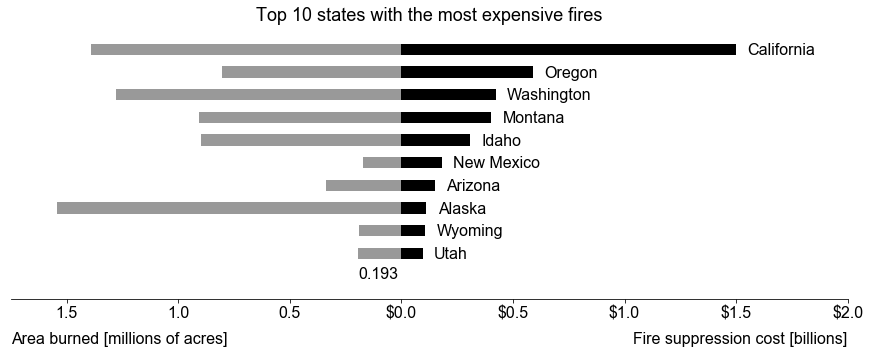

In [15]:
# Define quantities of interest
cost_mag = (np.floor(np.log10(series_costs.max())) // 3) * 3
area_mag = (np.floor(np.log10(-series_areas.min())) // 3) * 3


# Define figure parameters
fsize=16
fig, axes = plt.subplots(figsize=(15, 5))


# Make plot
plot = (series_costs / 10**cost_mag).plot.barh(color='k', fontsize=fsize, ax=axes)
(series_areas / 10**area_mag).plot.barh(color='0.6', fontsize=fsize, ax=axes)
axes.axis([-1.75, 2, -2, 10])


# Label plot
rects = axes.patches
state_labels = [abb_state[codes_state[state]] for state in index_states]
for i, (rect, state_label) in enumerate(zip(rects[:10], state_labels)):
    width = rect.get_width()
    axes.text(
        width + 0.05,
        rect.get_y() - rect.get_height() / 4.5,
        state_label,
        ha='left',
        va='bottom', 
        fontsize=fsize,
        fontname='Arial')
# Label the maxes and mins
axes.text(
        rects[int(np.floor(len(rects)/2))].get_width(),
        rects[int(np.floor(len(rects)/2))].get_y() - 2 * rects[int(np.floor(len(rects)/2))].get_height(),
        '%.3f' %(-series_areas.loc[49] / 10**area_mag),
        ha='left',
        va='bottom', 
        fontsize=fsize,
        fontname='Arial')
plot.set_yticklabels('')
plot.get_yaxis().set_visible(False)
plot.spines['right'].set_visible(False)
plot.spines['left'].set_visible(False)
plot.spines['top'].set_visible(False)
fig.canvas.draw()  # This needs to be called so that xtick labels are actually determined
xtick_labels = [i.get_text() for i in axes.get_xticklabels()]
for i in range(len(xtick_labels)):
    if i < int(np.floor(len(xtick_labels)/2)): # Flip left axis labels to be positive values
        xtick_labels[i] = xtick_labels[i][1:]
    else:
        xtick_labels[i] = '$' + xtick_labels[i]
axes.set_xticklabels(xtick_labels, fontsize=fsize, fontname='Arial')
axes.text(
    axes.get_xlim()[1], 
    -4, 
    'Fire suppression cost [%ss]' %units_dict[cost_mag], 
    ha='right', 
    fontsize=fsize, 
    fontname='Arial'
)
axes.text(
    axes.get_xlim()[0], 
    -4, 
    'Area burned [%ss of acres]' %units_dict[area_mag], 
    ha='left', 
    fontsize=fsize, 
    fontname='Arial'
)
axes.set_title('Top 10 states with the most expensive fires', fontsize=(fsize+2), fontname='Arial')
plt.show()
fig.savefig('./figures/cost_vs_area.pdf', bbox_inches="tight")

### Number of buildings destroyed and damaged
Let's focus further on the 3 states with the most expensive fires: California, Oregon and Washington, and compare the number of buildings destroyed and damaged, number of buildings threatened and cost of fire suppression.

In [16]:
series_costs = series_top20_costs.head(3)
index_states = series_costs.index
index_fires = [i[1] for i in df_all_final.groupby('POO_STATE_CODE')['FINAL_COST'].nlargest(20).loc[index_states].index]
df_states = df_all_final.loc[index_fires]

Generate a plot where each circle represents a fire. The position of the circle along the x-axis is its suppression cost, the position along the y-axis is the total number of buildings destroyed and damaged, and the size of the circle is the maximum number of buildings that were threatened during the fire.

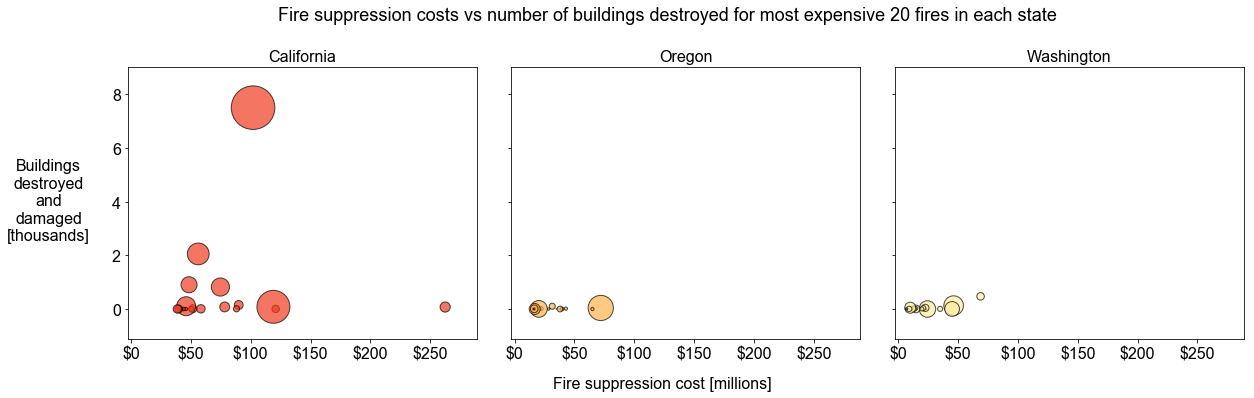

In [17]:
# Define quantities of interest
cost_mag = (np.floor(np.log10(df_states['FINAL_COST'].max())) // 3) * 3
dd_mag = (np.floor(np.log10(
    (df_states['FINAL_BUILDINGS_DESTROYED'] + df_states['FINAL_BUILDINGS_DAMAGED']).max()
)) // 3) * 3
threatened_mag = (np.floor(np.log10(df_states['MAX_BUILDINGS_THREATENED'].max())) // 3) * 3
xmax = df_states['FINAL_COST'].max() / 10**cost_mag
ymax = (df_states['FINAL_BUILDINGS_DESTROYED'] + df_states['FINAL_BUILDINGS_DAMAGED']).max() / 10**dd_mag

# Define figure parameters
fsize=16
color_list = ['#f03b20', '#feb24c', '#ffeda0']
fig, axes = plt.subplots(nrows = 1, ncols=3, sharey=True, sharex=True, figsize=(20, 5))


# Make plot
for i, state in enumerate(index_states):
    df_state = df_states[df_states['POO_STATE_CODE']==state]
    marker_height = (np.sqrt((df_state['MAX_BUILDINGS_THREATENED']) / np.pi) / 10**threatened_mag) * 15  # Arbitrary scaling factor
    axes[i].add_collection(
        EllipseCollection(
            widths=marker_height,
            heights=marker_height, 
            angles=0, 
            units='y', 
            facecolors=color_list[i], 
            edgecolors='k',
            alpha=0.7,
            offsets=list(
                zip(
                    list(df_state['FINAL_COST']) / 10**cost_mag, 
                    list(df_state['FINAL_BUILDINGS_DESTROYED'] + df_state['FINAL_BUILDINGS_DAMAGED']) / 10**dd_mag
            )
        ),
            transOffset=axes[i].transData
    )
    )
    axes[i].axis([0 - 0.01*xmax, 1.1*xmax, 0 - 0.15*ymax, 1.2*ymax])
    for tick in axes[i].get_yticklabels():
        tick.set_fontname('Arial')
        tick.set_fontsize(fsize)
    for tick in axes[i].get_xticklabels():
        tick.set_fontname('Arial')
        tick.set_fontsize(fsize)
    axes[i].set_title(abb_state[codes_state[state]], fontsize=fsize, family='Arial')

    
# Label plot
fig.subplots_adjust(wspace=0.1)
fig.text(0.42, -0.01, 'Fire suppression cost [%ss]' %units_dict[cost_mag], fontsize=fsize, family='Arial')
fig.text(0.07, 0.4, 'Buildings\ndestroyed\nand\ndamaged\n[%ss]' %units_dict[dd_mag], fontsize=fsize, family='Arial', ha='center')
fig.suptitle('Fire suppression costs vs number of buildings destroyed for most expensive 20 fires in each state', x=0.5, y=1.05, fontsize=(fsize+2), fontname='Arial')
fig.canvas.draw()
for j in range(3):
    xtick_labels = [i.get_text() for i in axes[j].get_xticklabels()]
    for i in range(len(xtick_labels)):
        xtick_labels[i] = '$' + xtick_labels[i]
    axes[j].set_xticklabels(xtick_labels, fontsize=fsize, fontname='Arial')
plt.show()
fig.savefig('./figures/cost_vs_destroyed.pdf', bbox_inches="tight")

Let's compare the number of buildings destroyed and damaged between California and Oregon's top 20 most expensive fires. How many times more buildings did California's most expensive fires damage/destroy compared to Oregon?

In [18]:
ca_destroyed_damaged = df_states[df_states['POO_STATE_CODE']==6][['FINAL_BUILDINGS_DESTROYED', 'FINAL_BUILDINGS_DAMAGED']].sum().sum()
or_destroyed_damaged = df_states[df_states['POO_STATE_CODE']==41][['FINAL_BUILDINGS_DESTROYED', 'FINAL_BUILDINGS_DAMAGED']].sum().sum()
ca_destroyed_damaged / or_destroyed_damaged

62.06315789473684

What about buliding destruction in California compared to Washington?

In [19]:
wa_destroyed_damaged = df_states[df_states['POO_STATE_CODE']==53][['FINAL_BUILDINGS_DESTROYED', 'FINAL_BUILDINGS_DAMAGED']].sum().sum()
ca_destroyed_damaged / wa_destroyed_damaged

15.294422827496758

We can also compare the number of buildings destroyed by state. First, we selected the 150 most destructive fires (in terms of `TOTAL_BUILDINGS_DESTROYED`):

In [20]:
# df_top_destroyed = df_all_final.sort_values('FINAL_BUILDINGS_DESTROYED', ascending=False).head(150)
# df_top_destroyed.to_csv('./data/top_150_buildings_destroyed.csv')

We manually reviewed the 150 most destructive fires and whittled it down to a list of 100. We can import these fires as a dataframe:

In [26]:
df_top_100_destroyed = pd.read_csv('./data/top_100_buildings_destroyed.csv')

Now, we categorize the most destructive fires by state and plot the number of most destructive fires by state in ascending order.

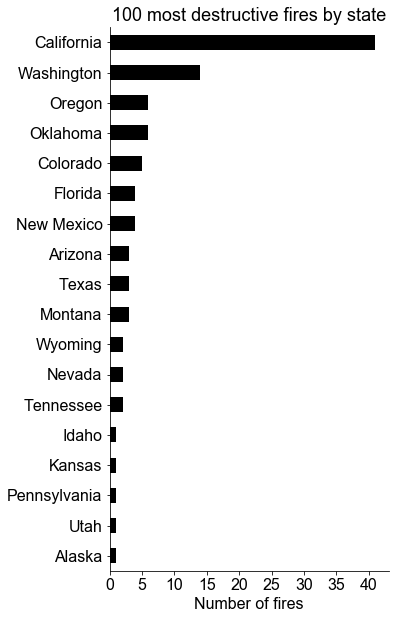

In [27]:
# Define quantities of interest
series_destroyed = df_top_100_destroyed.groupby('POO_STATE_CODE')['INC_IDENTIFIER'].count().sort_values()


# Define figure parameters
fsize=16
fig, axes = plt.subplots(nrows = 1, ncols=1, sharey=True, sharex=True, figsize=(5, 10))


# Make plot
plot = series_destroyed.plot.barh(color='k')
axes.set_yticklabels(
        labels=[abb_state[codes_state[i]] for i in series_destroyed.index],
        fontsize=fsize, fontname='Arial'
    )


# Label plot
axes.set_ylabel('')
axes.set_xlabel('Number of fires', fontsize=fsize, fontname='Arial')
for tick in axes.get_yticklabels():
    tick.set_fontname('Arial')
    tick.set_fontsize(fsize)
for tick in axes.get_xticklabels():
    tick.set_fontname('Arial')
    tick.set_fontsize(fsize)
axes.set_title('100 most destructive fires by state', fontsize=(fsize+2), fontname='Arial')
plot.spines['right'].set_visible(False)
plot.spines['top'].set_visible(False)
plt.show()
fig.savefig('./figures/destructive_by_state.pdf', bbox_inches="tight")

### WUI overlap
Now, we compare the WUI overlap for the most expensive fires in California, Oregon and Washington. For a more granular analysis, we join the SIT data with the GeoMAC/WUI data, which has more accurate fire perimeter and fire area information. The data sets are joined on the fire incident IDs (`incident_id` for the GeoMAC/WUI data set and `INC_IDENTIFIER` for the SIT data) which are then used as the index for the joined data frame.

In [28]:
series_costs = series_top20_costs.head(3)
index_states = series_costs.index
index_fires = [i[1] for i in df_all_final.groupby('POO_STATE_CODE')['FINAL_COST'].nlargest(20).loc[index_states].index]
df_states = df_all_final.loc[index_fires]
df_states_wui = df_states.join(df_wui.set_index('incident_id'), on='INC_IDENTIFIER')

We select only the fires which had a nonzero WUI overlap in each state (18 for California, 10 each in Oregon and Washington), and plot the fires in order of increasing WUI overlap.

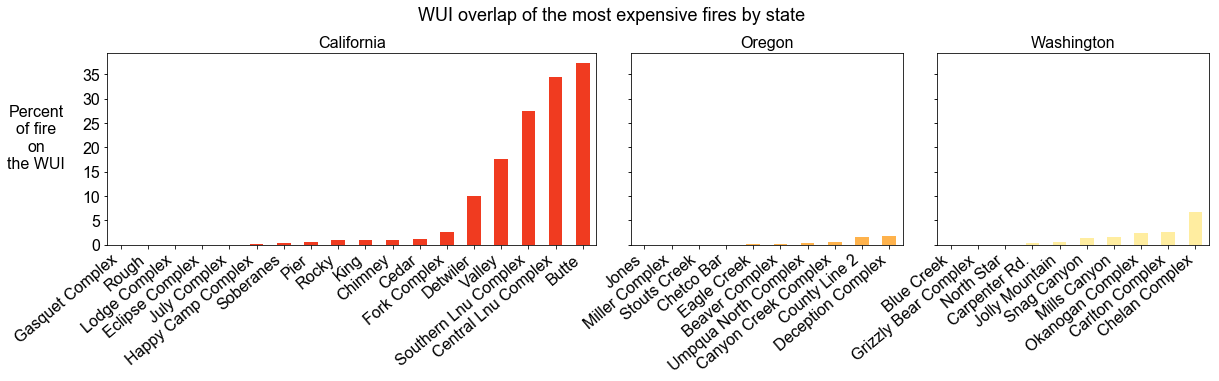

In [29]:
# Define figure parameters
fsize = 16
color_list = ['#f03b20', '#feb24c', '#ffeda0']
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(17, 5), gridspec_kw = {'width_ratios':[18, 10, 10]})


# Make plot
for i, state in enumerate(index_states):
    df_state = df_states_wui[(df_states_wui['POO_STATE_CODE']==state) & (df_states_wui['Total_WUI_Acreage'] > 0)]
    series_wui_pc = (df_state['Total_WUI_Acreage'] / df_state['Total_Fire_Acreage']).sort_values()
    subplot = (series_wui_pc * 100).plot.bar(ax=axes[i], fontsize=fsize, color=color_list[i])
    subplot.set_title(abb_state[codes_state[state]], fontsize=fsize, fontname='Arial')
    subplot.set_xticklabels(
        labels=[df_states.loc[i, 'INCIDENT_NAME'].title() for i in series_wui_pc.index], 
        rotation=40, 
        ha='right',
        fontsize=fsize, 
        fontname='Arial'
    )
    subplot.set_xlabel('')
    for tick in axes[i].get_yticklabels():
        tick.set_fontname('Arial')
        tick.set_fontsize(fsize)
        

# Label plot
fig.tight_layout()
fig.subplots_adjust(wspace=0.1)
fig.suptitle('WUI overlap of the most expensive fires by state', x=0.5, y=1.05, fontsize=(fsize+2), fontname='Arial')
fig.text(0.03, 0.6, 'Percent\nof fire\non\nthe WUI', fontsize=fsize, fontname='Arial', ha='center')
plt.show()
fig.savefig('./figures/wui_overlap.pdf', bbox_inches="tight")

Let's check in on the Butte fire in California

In [30]:
df_states_wui[df_states_wui['INCIDENT_NAME']=='BUTTE']['Total_WUI_Acreage'] / \
df_states_wui[df_states_wui['INCIDENT_NAME']=='BUTTE']['Total_Fire_Acreage']

INC_IDENTIFIER
2910134.0    0.374221
dtype: float64

Let's check the max WUI overlap for fires in California, and number of fires with nonzero WUI overlap:

In [31]:
series_or_wui = (df_states_wui[df_states_wui['POO_STATE_CODE'] == 6]['Total_WUI_Acreage'] / \
df_states_wui[df_states_wui['POO_STATE_CODE'] == 6]['Total_Fire_Acreage'])
series_or_wui.sort_values(ascending=False)

INC_IDENTIFIER
2910134.0    0.374221
7293180.0    0.344198
7200218.0    0.275358
2915082.0    0.176429
7170139.0    0.100086
2753601.0    0.027190
4277928.0    0.012392
4367985.0    0.010242
983669.0     0.009286
2743187.0    0.009270
7385500.0    0.006295
4327598.0    0.004030
809568.0     0.001346
744756.0     0.000285
7396234.0    0.000136
731475.0     0.000049
2770813.0    0.000011
2781653.0    0.000008
7377619.0    0.000000
7382007.0    0.000000
dtype: float64

And in Oregon:

In [32]:
series_or_wui = (df_states_wui[df_states_wui['POO_STATE_CODE'] == 41]['Total_WUI_Acreage'] / \
df_states_wui[df_states_wui['POO_STATE_CODE'] == 41]['Total_Fire_Acreage'])
series_or_wui.sort_values(ascending=False)

INC_IDENTIFIER
865852.0     0.018035
2922269.0    0.016225
2870956.0    0.006052
7343355.0    0.003939
738768.0     0.001048
7363775.0    0.000753
7265708.0    0.000299
2749560.0    0.000071
7253911.0    0.000061
7346754.0    0.000049
750301.0     0.000000
2789124.0    0.000000
7400161.0    0.000000
7278759.0    0.000000
7208972.0    0.000000
4345649.0    0.000000
7231210.0    0.000000
647372.0     0.000000
7272173.0    0.000000
875523.0     0.000000
dtype: float64

And in Washington:

In [33]:
series_wa_wui = (df_states_wui[df_states_wui['POO_STATE_CODE'] == 53]['Total_WUI_Acreage'] / \
df_states_wui[df_states_wui['POO_STATE_CODE'] == 53]['Total_Fire_Acreage'])
series_wa_wui.sort_values(ascending=False)

INC_IDENTIFIER
2906716.0    0.068260
638842.0     0.027360
2931055.0    0.023569
603061.0     0.015613
750232.0     0.013659
7350855.0    0.006608
2938854.0    0.002793
2867919.0    0.000201
2878511.0    0.000117
2837946.0    0.000079
2806273.0    0.000000
2860062.0    0.000000
782958.0     0.000000
7274496.0    0.000000
778078.0     0.000000
7216628.0    0.000000
750343.0     0.000000
2816040.0    0.000000
7250173.0    0.000000
7373517.0    0.000000
dtype: float64

### Visualize WUI housing trends over the years
Let's find which five states had the highest density of housing in the WUI in 2010, and track how those trends have changed since 1990.

In [34]:
df_wui_top5 = df_wui_housing.sort_values('Houses in the WUI 2010', ascending=False).head(5)[
    ['Houses in the WUI 1990', 'Houses in the WUI 2000','Houses in the WUI 2010']
].transpose()
df_wui_top5.index = [int(i.split(' ')[-1]) for i in df_wui_top5.index]

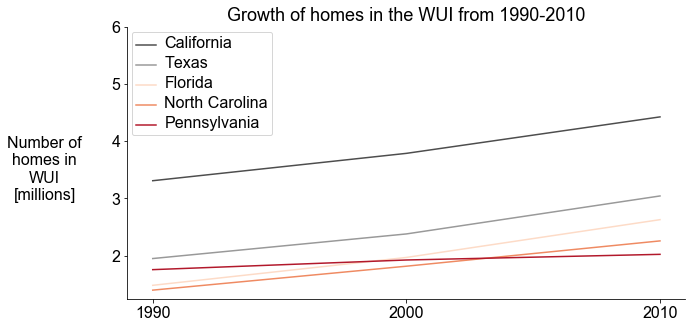

In [35]:
# Define quantities of interest
housing_mag = (np.floor(np.log10(df_wui_housing['Houses in the WUI 2010'].max())) // 3) * 3


# Define figure parameters
fsize = 16
color_list = [
    '#4d4d4d', '#999999', '#fddbc7', '#ef8a62', '#b2182b'
]
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))


# Make plot
plot = (df_wui_top5 / 10**housing_mag).plot(ax=axes, color=color_list, xticks=df_wui_top5.index)


# Label plot
axes.set_xlabel('')
for tick in axes.get_yticklabels():
    tick.set_fontname('Arial')
    tick.set_fontsize(fsize)
for tick in axes.get_xticklabels():
    tick.set_fontname('Arial')
    tick.set_fontsize(fsize)
axes.set_title('Growth of homes in the WUI from 1990-2010', fontsize=(fsize+2), fontname='Arial')
fig.text(0.01, 0.4, 'Number of\nhomes in\nWUI\n[%ss]' %units_dict[housing_mag], fontsize=fsize, family='Arial', ha='center')
plot.spines['right'].set_visible(False)
plot.spines['top'].set_visible(False)
plt.setp(axes.legend().texts, family='Arial', fontsize=16)
plt.gca().set_ylim(top=6)
plt.show()
fig.savefig('./figures/wui_growth.pdf', bbox_inches="tight")